# Imports

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
from pathlib import Path
import scipy.signal as signal
 
# from DSPFuncs import DCRemover
import Adaptive
import CantileverBeam
import DSPFuncs
import ActVibSystem
importlib.reload(CantileverBeam)
importlib.reload(Adaptive)
importlib.reload(DSPFuncs)
importlib.reload(ActVibSystem)


<module 'ActVibSystem' from 'd:\\Universidade\\_pesquisa\\Vibracoes\\ActVibModules\\ActVibSystem.py'>

# Cantilever Beam Frequencies and Modes

Natural frequencies are: [  6.14859366  38.52820754 107.86906612 211.35813792].


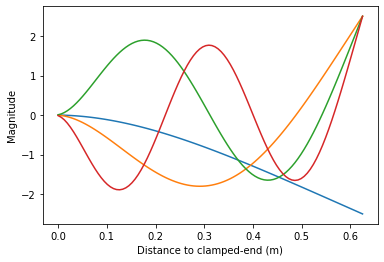

In [2]:
# A beam instance with length of 62.5 cm, width of 4.3 cm and thicknes of 3 mm:
beam = CantileverBeam.CantileverBeam(npoints=100,length=62.5e-2,width=4.3e-2,thickness=3e-3,nmodes=4)

# Natural frequencies in beam.freqHz
print(f"Natural frequencies are: {beam.freqsHz}.")

# Mode shape plots
x,modes = beam.getModeShapes()
# plotting one shape for each mode:
fig,ax = plt.subplots(1,1)
for n in range(beam.nmodes):
    ax.plot(x,modes[:,n])
ax.set_xlabel("Distance to clamped-end (m)")
ax.set_ylabel("Magnitude")

plt.show()

# Adaptive System Identification

In [4]:
data = pd.read_parquet((Path() / "SampleSignals"  / "Measurements1.parquet"))
display(data.head(5))

,Tempo (s),DAC 1,DAC 2,DAC 3,DAC 4,IMU1AccX,IMU1AccY,IMU1AccZ,IMU1GyroX,IMU1GyroY,IMU1GyroZ,IMU2AccX,IMU2AccY,IMU2AccZ,IMU2GyroX,IMU2GyroY,IMU2GyroZ
0,0.000,-0.435851,-1.0,-1.0,-1.0,0.187945,9.740809,0.486023,4.333496,-3.326416,-3.601074,0.169988,9.731233,0.676362,2.044678,-6.866455,-2.426147
1,0.004,-0.528777,-1.0,-1.0,-1.0,0.187945,9.740809,0.486023,4.333496,-3.326416,-3.601074,0.159214,9.715670,0.604536,2.136230,-6.835938,-2.410889
2,0.008,0.193046,-1.0,-1.0,-1.0,0.180762,9.740809,0.579397,4.119873,-3.372192,-3.631592,0.159214,9.715670,0.604536,2.136230,-6.835938,-2.410889
3,0.012,0.143285,-1.0,-1.0,-1.0,0.180762,9.740809,0.579397,4.119873,-3.372192,-3.631592,0.159214,9.715670,0.604536,2.136230,-6.835938,-2.410889
4,0.016,-0.440647,-1.0,-1.0,-1.0,0.180762,9.740809,0.579397,4.119873,-3.372192,-3.631592,0.186748,9.805453,1.221043,2.578735,-6.866455,-2.502441


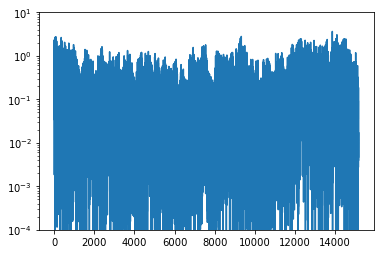

In [7]:

indata = data["DAC 1"].values  # Input signal: does not need to remove DC level since this signal is already zero mean
outdata = DCRemover().filter(data["IMU2AccZ"].values)  # Remove DC level from output signal, making convergence faster. 

# Create instance of FIR-NLMS adaptive filter, which will be used for modeling the desired path/system:
firnlms = Adaptive.FIRNLMS(memorysize=2500,stepsize=0.5,regularization=1e-3)  # memorysize = number of filter coeficients, stepsize = must be smaller than one, regularization = noise variance is a good choice.


# Run the system modeling using the FIR-NLMS filter:
firnlms.run(indata, outdata, maxiter=None)

# Plot the squared error observed during the modeling.
plt.semilogy(firnlms.sqerror)
plt.ylim(1e-4,1e1)
plt.show()


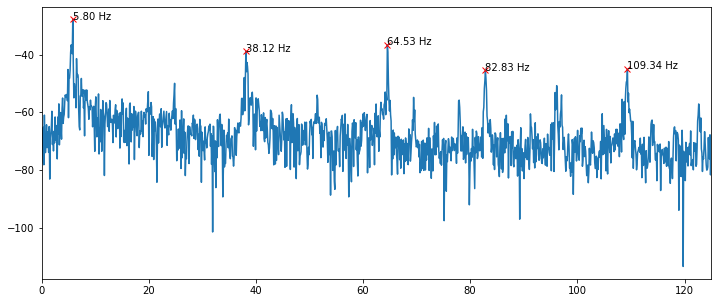

In [9]:
# Now, by taking the fft of the obtained coefficient vector (obtained impulse response), 
# we can observe the frequency response of the system:
# Coefficient vector is given by firnlms.ww. 

magfftdb = 20*np.log10(1/250*np.abs(np.fft.fft(firnlms.ww)))
freqs = np.linspace(0, 250, magfftdb.shape[0])

fig,ax = plt.subplots(1,1)
ax.plot(freqs,magfftdb)

peaks,props = signal.find_peaks(magfftdb,distance=50,height=-48)
npeaks = 5 # Até 5 picos serão considerados
peakfreqs = freqs[peaks[0:npeaks]]  # Os npeaks primeiros
peakvals = props['peak_heights'][0:npeaks]  # Os npeaks primeiros
ax.plot(peakfreqs,peakvals,"xr")
for k in range(min([npeaks,peakfreqs.shape[0]])):
  if peakfreqs[k] <= 125: # somente plota até 125 Hz
    ax.text(peakfreqs[k],peakvals[k],f"{peakfreqs[k]:.2f} Hz")

ax.set_xlim(0,125)
fig.set_size_inches(12,5)

plt.show()

# Rotation Test

[ 13.54532293  84.86034667 237.54395691]


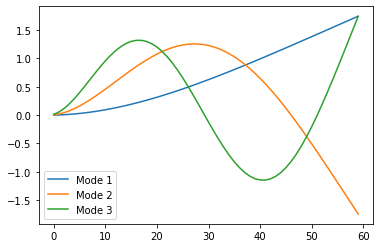

In [82]:
beam = CantileverBeam.CantileverBeam(nmodes=3)
print(beam.freqsHz)
x,m = beam.getModeShapes()
for k in range(beam.nmodes):
    plt.plot(m[:,k],label=f"Mode {k+1}")
plt.legend()
plt.show()

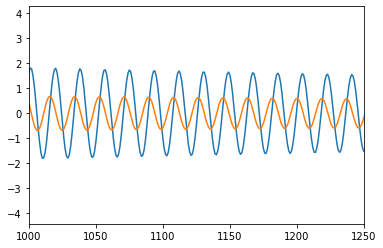

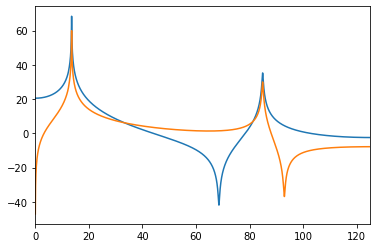

In [71]:
saidarot = np.zeros(10000)
saidadesl = np.zeros(10000)
beam.reset()
beam.setforce(50, 1)
beam.update()
saidarot[0] = beam.rotvel[40]
saidadesl[0] = beam.getaccelms2(40)
beam.setforce(10, 0)
beam.update()
saidarot[1] = beam.rotvel[40]
saidadesl[1] = beam.getaccelms2(40)
for k in range(2,10000):
    beam.update()
    saidarot[k] = beam.rotvel[40]
    saidadesl[k] = beam.getaccelms2(40)
plt.plot(saidarot)
plt.plot(saidadesl)
plt.xlim(1000,1250)
plt.show()

fig,ax = plt.subplots(1,1)
magfftdb = 20*np.log10(np.abs(np.fft.fft(saidarot)))
magfftdb2 = 20*np.log10(np.abs(np.fft.fft(saidadesl)))
freqs = np.linspace(0, 250, magfftdb.shape[0])

ax.plot(freqs,magfftdb)
ax.plot(freqs,magfftdb2)
ax.set_xlim(0,125)

plt.show()

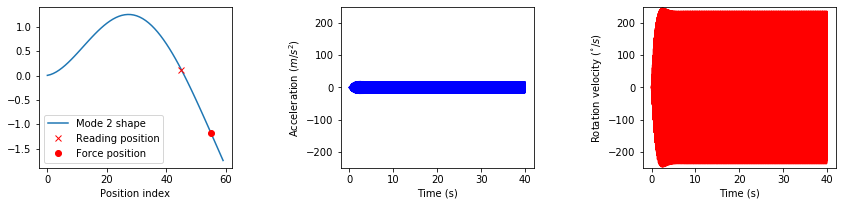

In [116]:
N = 10000
freqsampling = 250
freqx = 85.0
posreading = 45
posforce = 55
fig,ax = plt.subplots(1,3)
ax[0].plot(beam.vmod[:,1],label="Mode 2 shape")
ax[0].plot(posreading,beam.vmod[posreading,1],"rx",label="Reading position")
ax[0].plot(posforce,beam.vmod[posforce,1],"ro",label="Force position")
ax[0].set_xlabel("Position index")
ax[0].legend()

beam.reset()
x = np.zeros(N)
yaccel = np.zeros(N)
rotvel = np.zeros(N)
for n in range(N):
    x[n] = np.sin(2*np.pi*freqx*n/freqsampling)  # generating sinusoid with freqx Hz
    beam.setforce(posforce, x[n])
    beam.update()
    yaccel[n] = beam.getaccelms2(posreading)
    rotvel[n] = beam.rotvel[posreading]

t = np.linspace(0, N/freqsampling, N)
ax[1].plot(t,yaccel,'b')
ax[1].set_ylabel("Acceleration ($m/s^2$)")
ax[2].plot(t,rotvel,'r')
ax[2].set_ylabel("Rotation velocity ($^{\circ}/s$)")
for axx in ax[1:]:
    axx.set_xlabel("Time (s)")
    axx.set_ylim(-250,250)

fig.tight_layout(pad=0)
fig.set_size_inches(12,2.5)
plt.show()

# Testing the easyFourier function

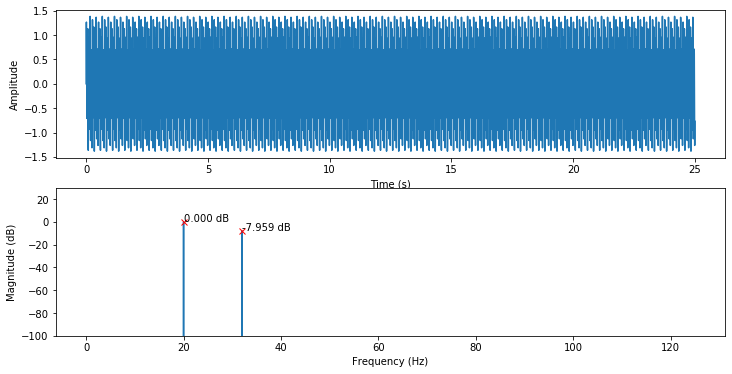

In [3]:
fs = 250
t = np.arange(0,25,step=1/fs)

freqsin = 20
freqsin2 = 32
testsignal = np.sin(2*np.pi*freqsin*t) + 0.4*np.sin(2*np.pi*freqsin2*t)

fig,ax = plt.subplots(2,1)
ax[0].plot(t,testsignal)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")

magdb,freqs = DSPFuncs.easyFourier(testsignal,fs)
ax[1].plot(freqs,magdb)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Magnitude (dB)")

pos20 = np.where(freqs == 20.0)[0][0]
ax[1].plot(freqs[pos20],magdb[pos20],"xr")
ax[1].text(freqs[pos20],magdb[pos20],f"{magdb[pos20]:.3f} dB")

pos32 = np.where(freqs == 32.0)[0][0]
ax[1].plot(freqs[pos32],magdb[pos32],"xr")
ax[1].text(freqs[pos32],magdb[pos32],f"{magdb[pos32]:.3f} dB")

ax[1].set_ylim(-100,30)

fig.set_size_inches(12,6)
plt.show()

# Testing ActVibData Class

In [111]:
importlib.reload(ActVibSystem)

<module 'ActVibSystem' from 'd:\\Universidade\\_pesquisa\\Vibracoes\\ActVibModules\\ActVibSystem.py'>

In [112]:
# myfile = ActVibSystem.ActVibData("SampleSignals\M1.feather")
myfile = ActVibSystem.ActVibData("SampleSignals\\aaa.feather")
print(list(myfile.getSignalNames()))

['Tempo (s)', 'DAC 1', 'DAC 2', 'DAC 3', 'DAC 4', 'ADC 1.1', 'ADC 2.1', 'ADC 3.1', 'ADC 4.1', 'IMU1AccX', 'IMU1AccY', 'IMU1AccZ', 'IMU1GyroX', 'IMU1GyroY', 'IMU1GyroZ', 'Log']


In [113]:
print(myfile.getNotes())

Eita!
Será
que
funciona?
Bem 
isso?


In [114]:
display(myfile.getLogs())

[[0.004, 'Started'],
 [0.008, 'IMU1|MPU6050|0x68|I2C-1|±2g (±19,6m/s²)|±250º/s|260Hz'],
 [0.012, 'IMU2|Disabled'],
 [0.016, 'IMU3|Disabled'],
 [0.02, 'ADC|ADS1115|1|0|0|0|±6,144 V|860 SPS'],
 [0.024, 'Gen1|Enabled|Square|0.5|10.0|1668'],
 [0.028, 'Gen2|Disabled'],
 [0.032, 'Gen3|Disabled'],
 [0.036000000000000004, 'Gen4|Disabled'],
 [5.0, 'Gen1|Enabled|Harmonic|0.5|10.0|1668'],
 [6.0, 'Stopped'],
 [8.684000015258789, 'Started'],
 [8.688000015258789, 'IMU1|MPU6050|0x68|I2C-1|±2g (±19,6m/s²)|±250º/s|260Hz'],
 [8.692000015258788, 'IMU2|Disabled'],
 [8.69600001525879, 'IMU3|Disabled'],
 [8.700000015258789, 'ADC|ADS1115|1|0|0|0|±6,144 V|860 SPS'],
 [8.704000015258789, 'Gen1|Enabled|Harmonic|0.5|10.0|1668'],
 [8.708000015258788, 'Gen2|Disabled'],
 [8.71200001525879, 'Gen3|Disabled'],
 [8.716000015258789, 'Gen4|Disabled'],
 [12.00000001525879, 'Stopped']]

In [117]:
print(myfile.getADCData(1))
print(myfile.getADC1kHzData())

[ 0.000375   0.0013125  0.0016875 ... -0.000375   0.0013125  0.0015   ]
[0.000375  0.0031875 0.0046875 ... 0.0045    0.000375  0.0020625]


In [118]:
display(myfile.data.head(5)) 

,Tempo (s),DAC 1,DAC 2,DAC 3,DAC 4,ADC 1.1,ADC 2.1,ADC 3.1,ADC 4.1,IMU1AccX,IMU1AccY,IMU1AccZ,IMU1GyroX,IMU1GyroY,IMU1GyroZ,Log
0,0.000,0.5,-1.0,-1.0,-1.0,0.000375,0.003188,0.004687,0.001313,0.086191,9.469068,-2.173935,-2.601624,-1.182556,-0.175476,Eita!\nSerá\nque\nfunciona?\nBem \nisso?
1,0.004,0.5,-1.0,-1.0,-1.0,0.001313,0.004687,0.001125,0.000000,0.146046,9.454702,-2.190695,-2.540588,-1.022339,-0.030518,Started
2,0.008,0.5,-1.0,-1.0,-1.0,0.001687,0.003375,0.003375,-0.000188,0.086191,9.418789,-2.286463,-2.563477,-0.991821,-0.083923,"IMU1|MPU6050|0x68|I2C-1|±2g (±19,6m/s²)|±250º/..."
3,0.012,0.5,-1.0,-1.0,-1.0,-0.000188,0.001687,0.000563,0.000000,0.052672,9.428366,-2.209848,-2.624512,-0.946045,-0.091553,IMU2|Disabled
4,0.016,0.5,-1.0,-1.0,-1.0,0.000000,0.005438,0.001875,0.000188,0.098162,9.473856,-2.116474,-2.624512,-0.869751,-0.289917,IMU3|Disabled
